<a href="https://www.kaggle.com/code/oscarm524/ps-s3-ep24-eda-modeling-submission?scriptVersionId=148006044" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a id="table"></a>
<h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Table of Contents</h1>

[1. Notebook Versions](#1)

[2. Loading Libraries](#2)

[3. Reading Data Files](#3)

[4. Data Exploration](#4)

[5. Baseline Modeling 1.0](#5)

[6. Baseline Modeling 2.0](#6)

<a id="1"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Notebook Versions</h1>

- Version 1 (10/23/2023)
    * EDA 
    * Baseline modeling 1.0
    
    
- Version 2 (10/24/2023)
    * Baseline modeling 1.0 updated
    
    
- Version 3 (10/24/2023)
    * Baseline modeling 1.0 updated (more models added)
    
    
- Version 4 (10/25/2023)
    * Baseline modeling 2.0 added


<a id="2"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Loading Libraries</h1>    

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm.notebook import tqdm

import re

from functools import partial
from scipy.stats import mode

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer, PowerTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.manifold import TSNE
import optuna

<a id="3"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Reading Data Files</h1> 

In [2]:
train = pd.read_csv('../input/playground-series-s3e24/train.csv')
test = pd.read_csv('../input/playground-series-s3e24/test.csv')
submission = pd.read_csv('../input/playground-series-s3e24/sample_submission.csv')

print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)

The dimension of the train dataset is: (159256, 24)
The dimension of the test dataset is: (106171, 23)


In [3]:
train.describe()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000
mean,79627.500000,44.306626,165.266929,67.143662,83.001990,1.005798,1.000989,1.023974,1.023421,122.503648,76.874071,98.352552,195.796165,127.616046,55.852684,114.607682,14.796965,1.074233,0.892764,25.516853,26.550296,36.216004,0.197996,0.437365
std,45973.391572,11.842286,8.818970,12.586198,8.957937,0.402113,0.392299,0.152969,0.151238,12.729315,8.994642,15.329740,28.396959,66.188989,13.964141,28.158931,1.431213,0.347856,0.179346,9.464882,17.753070,31.204643,0.398490,0.496063
min,0.000000,20.000000,135.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,77.000000,44.000000,46.000000,77.000000,8.000000,9.000000,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000,0.000000
25%,39813.750000,40.000000,160.000000,60.000000,77.000000,0.800000,0.800000,1.000000,1.000000,114.000000,70.000000,90.000000,175.000000,77.000000,45.000000,95.000000,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000,0.000000
50%,79627.500000,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,78.000000,96.000000,196.000000,115.000000,54.000000,114.000000,15.000000,1.000000,0.900000,24.000000,22.000000,27.000000,0.000000,0.000000
75%,119441.250000,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,82.000000,103.000000,217.000000,165.000000,64.000000,133.000000,15.800000,1.000000,1.000000,29.000000,32.000000,44.000000,0.000000,1.000000
max,159255.000000,85.000000,190.000000,130.000000,127.000000,9.900000,9.900000,2.000000,2.000000,213.000000,133.000000,375.000000,393.000000,766.000000,136.000000,1860.000000,21.000000,6.000000,9.900000,778.000000,2914.000000,999.000000,1.000000,1.000000


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   159256 non-null  int64  
 1   age                  159256 non-null  int64  
 2   height(cm)           159256 non-null  int64  
 3   weight(kg)           159256 non-null  int64  
 4   waist(cm)            159256 non-null  float64
 5   eyesight(left)       159256 non-null  float64
 6   eyesight(right)      159256 non-null  float64
 7   hearing(left)        159256 non-null  int64  
 8   hearing(right)       159256 non-null  int64  
 9   systolic             159256 non-null  int64  
 10  relaxation           159256 non-null  int64  
 11  fasting blood sugar  159256 non-null  int64  
 12  Cholesterol          159256 non-null  int64  
 13  triglyceride         159256 non-null  int64  
 14  HDL                  159256 non-null  int64  
 15  LDL              

In [5]:
test.describe()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
count,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000
mean,212341.000000,44.426538,165.221322,67.125618,82.999892,1.004776,0.999483,1.024216,1.023980,122.475403,76.820676,98.397943,195.874391,127.406203,55.922286,114.597404,14.793354,1.072798,0.892463,25.559616,26.565427,36.086888,0.195458
std,30649.072052,11.897138,8.837065,12.586569,8.946584,0.397690,0.385752,0.153719,0.152988,12.765542,9.018782,15.337904,28.435413,66.352488,14.000552,26.943401,1.434296,0.340818,0.179927,9.504442,17.944195,30.928138,0.396555
min,159256.000000,20.000000,135.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,71.000000,40.000000,46.000000,66.000000,8.000000,18.000000,1.000000,5.000000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000
25%,185798.500000,40.000000,160.000000,60.000000,77.000000,0.800000,0.800000,1.000000,1.000000,114.000000,70.000000,90.000000,175.000000,77.000000,45.000000,95.000000,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000
50%,212341.000000,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,78.000000,96.000000,196.000000,114.000000,54.000000,114.000000,15.000000,1.000000,0.900000,24.000000,22.000000,27.000000,0.000000
75%,238883.500000,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,82.000000,103.000000,217.000000,164.000000,64.000000,133.000000,15.800000,1.000000,1.000000,29.000000,33.000000,44.000000,0.000000
max,265426.000000,85.000000,190.000000,130.000000,127.700000,9.900000,9.900000,2.000000,2.000000,213.000000,140.000000,423.000000,369.000000,548.000000,148.000000,1220.000000,21.100000,6.000000,9.900000,778.000000,2914.000000,999.000000,1.000000


There are no missing values neither in `train` and `test` datasets.

<a id="4"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data Exploration</h1>

First, we start by visualizing `smoking`, the variable of interest.

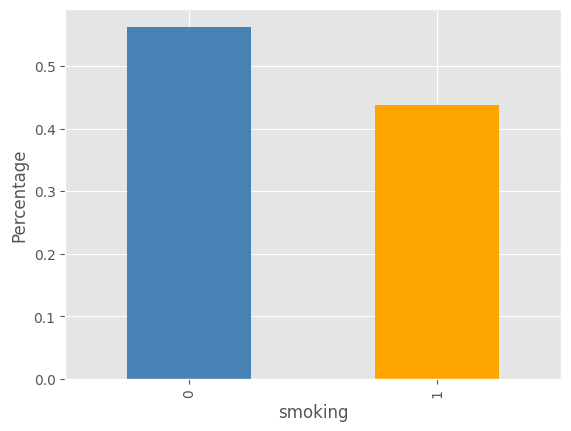

In [6]:
train['smoking'].value_counts(normalize = True).plot(kind = 'bar', color = ['steelblue', 'orange'])
plt.ylabel('Percentage');

From the above bar chart, we see the data is pretty balanced (~44% 0s and 56% 1s). Next we explore the relationship between `age` and `smoking`.

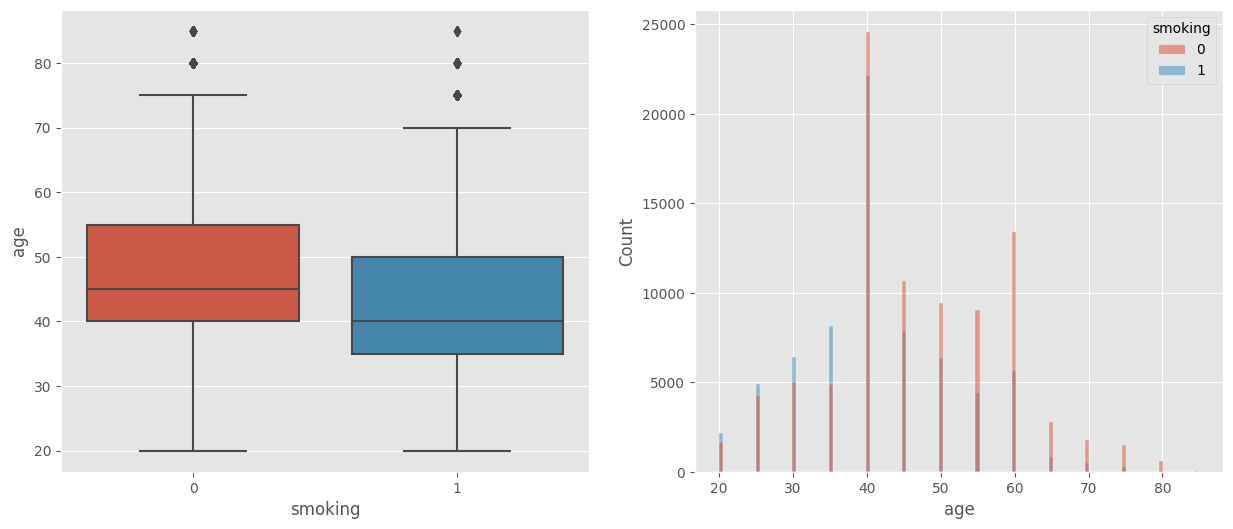

In [7]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.boxplot(ax = axes[0], data = train, x = 'smoking', y = 'age');
sns.histplot(data = train, x = 'age', hue = 'smoking');

From the above, these are a couple of observations:

- From the left panel, we observe the median age of non-smokers is about 5 years larger when comapred to the median age of smokers. 
- From the right panel, it seems that age is a discrete variable.

In [8]:
print(f"There are {train['age'].nunique()} unique age values in the train dataset")
print(f"{train['age'].unique()} \n")
print(f"There are {test['age'].nunique()} unique age values in the test dataset")
print(f"{test['age'].unique()} \n")

There are 18 unique age values in the train dataset
[55 70 20 35 30 50 45 40 60 25 65 75 80 85 62 69 49 58] 

There are 18 unique age values in the test dataset
[40 80 60 55 70 45 30 25 50 35 20 75 65 85 78 69 64 24] 



Notice that the `age` values are not the same in the `train` and `test` datasets. Next, we explore the relationship between `height(cm)`, `weight(kg)`, `waist(cm)` and `smoking`.

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


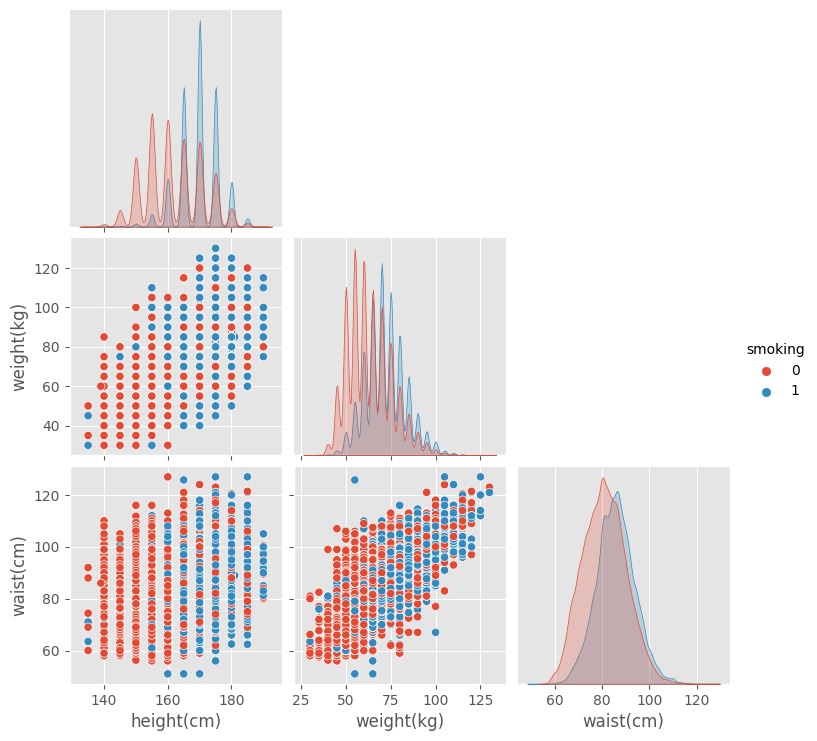

In [9]:
sns.pairplot(data = train[['height(cm)', 'weight(kg)', 'waist(cm)', 'smoking']], hue = 'smoking', corner = True);

From the above pair-plots, these are a couple of observations:

- Taller people (heavier as well) tend to smoke.
- The relationship between `weight(kg)` and `waist(cm)` is more or less linear.

Next, we explore the relationship between `eyesight` and `smoking`.

In [10]:
pd.crosstab(train['eyesight(left)'], train['smoking'], normalize = 'index')

smoking,0,1
eyesight(left),,
0.1,0.669014,0.330986
0.2,0.694143,0.305857
0.3,0.703356,0.296644
0.4,0.707522,0.292478
0.5,0.665833,0.334167
0.6,0.671148,0.328852
0.7,0.640735,0.359265
0.8,0.622629,0.377371
0.9,0.585788,0.414212


From the above, these are a couple of observations:

- 9.9 is very different from the other values.
- There are a few values (9.9, 1.6, 1.3, 1.8, 1.9, 1.1, 1.7) with low frequency.

In [11]:
pd.crosstab(train['eyesight(right)'], train['smoking'], normalize = 'index')

smoking,0,1
eyesight(right),,
0.1,0.704857,0.295143
0.2,0.694311,0.305689
0.3,0.716919,0.283081
0.4,0.700000,0.300000
0.5,0.678143,0.321857
0.6,0.690966,0.309034
0.7,0.652750,0.347250
0.8,0.637278,0.362722
0.9,0.568484,0.431516


From the above, these are a couple of observations:

- 9.9 is very different from the other values.
- There are a few values (9.9, 1.6, 1.3, and 1.4) with low frequency.

Next, we explore the relationship between `hearing` and `smoking`.

In [12]:
pd.crosstab(train['hearing(left)'], train['smoking'], normalize = 'index')

smoking,0,1
hearing(left),,
1,0.559664,0.440336
2,0.683604,0.316396


In [13]:
pd.crosstab(train['hearing(right)'], train['smoking'], normalize = 'index')

smoking,0,1
hearing(right),,
1,0.559804,0.440196
2,0.680697,0.319303


From the above, these are a couple of observations;

- When `hearing = 1` about 56% are non-smokers (regardless right or left).
- When `hearing = 2` about 68% are non-smokers (regardless right or left).


Next, we explore the relationship between `systolic` and `smoking`.

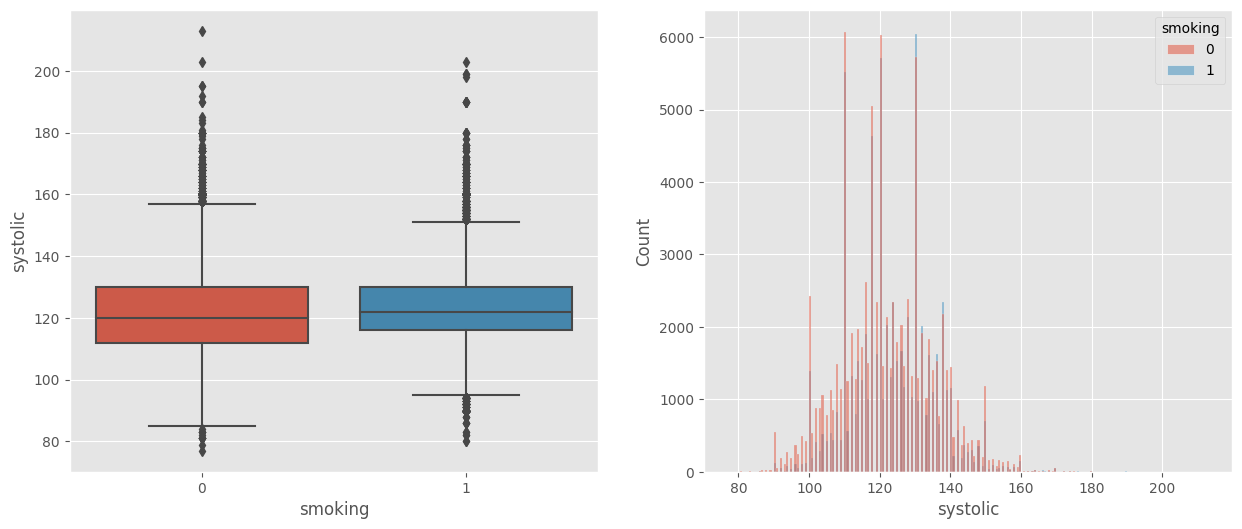

In [14]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.boxplot(ax = axes[0], data = train, x = 'smoking', y = 'systolic');
sns.histplot(data = train, x = 'systolic', hue = 'smoking');

The `systolic` distributions of non-smokers and smokers are very similar. Next, we explore the relationship between`relaxation` and `smoking`.

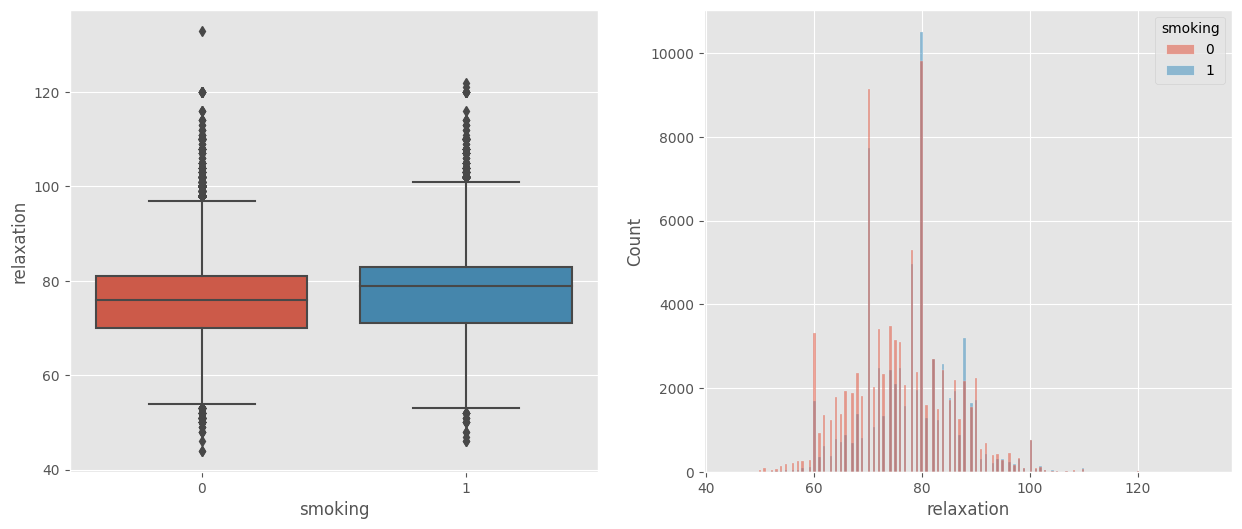

In [15]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.boxplot(ax = axes[0], data = train, x = 'smoking', y = 'relaxation');
sns.histplot(data = train, x = 'relaxation', hue = 'smoking');

The `relaxation` distributions of non-smokers and smokers are very similar. Next, we explore the relationship between`fasting blood sugar` and `smoking`.

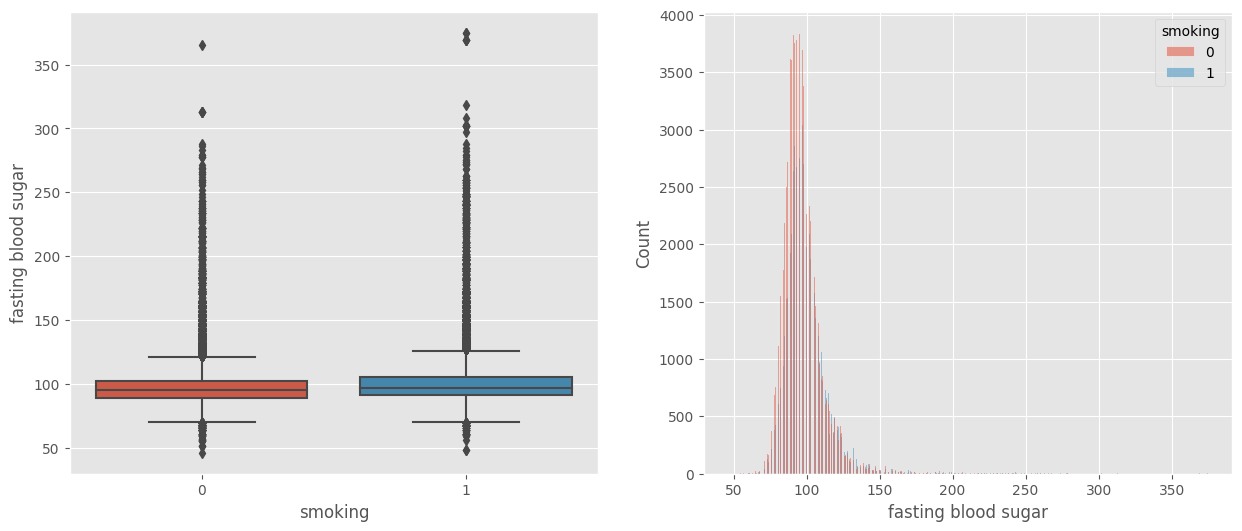

In [16]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.boxplot(ax = axes[0], data = train, x = 'smoking', y = 'fasting blood sugar');
sns.histplot(data = train, x = 'fasting blood sugar', hue = 'smoking');

The `fasting blood sugar` distributions of non-smokers and smokers are very similar. Next, we explore the relationship between`Cholesterol` and `smoking`.

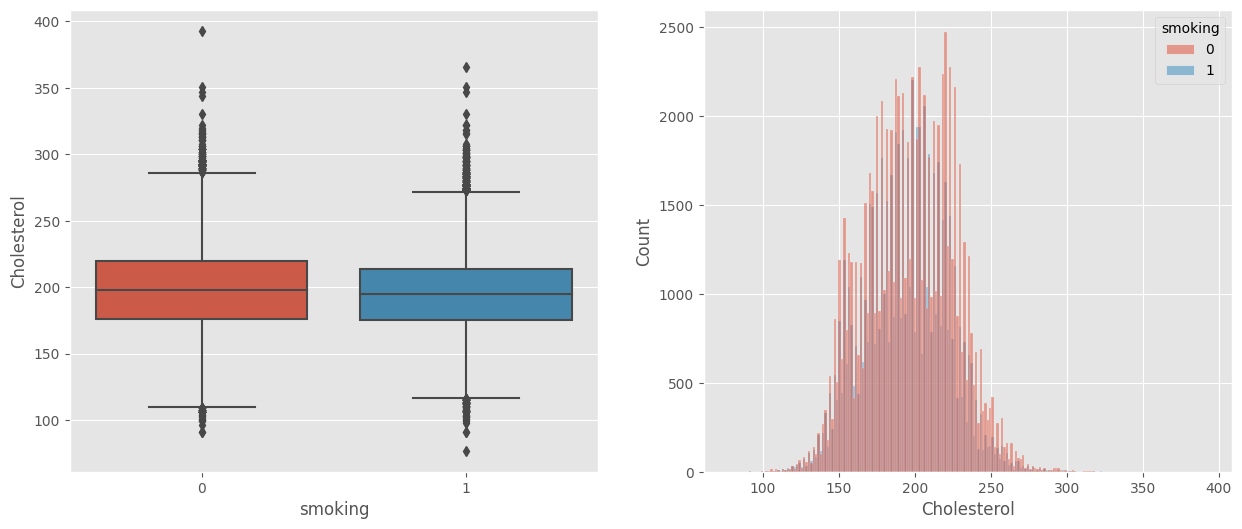

In [17]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.boxplot(ax = axes[0], data = train, x = 'smoking', y = 'Cholesterol');
sns.histplot(data = train, x = 'Cholesterol', hue = 'smoking');

The `Cholesterol` distributions of non-smokers and smokers are very similar. Next, we explore the relationship between`triglyceride` and `smoking`.

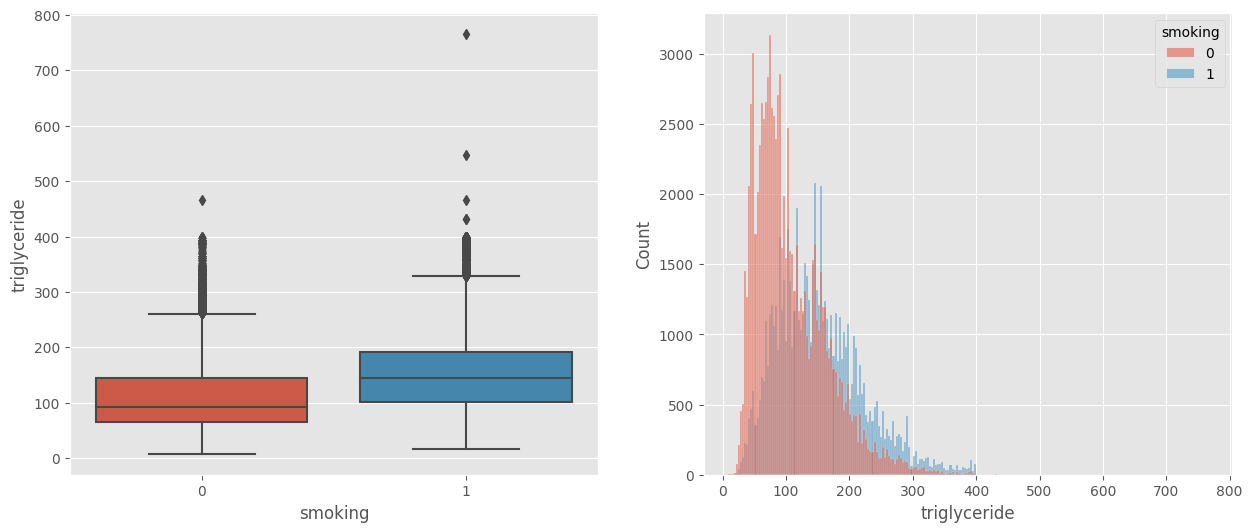

In [18]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.boxplot(ax = axes[0], data = train, x = 'smoking', y = 'triglyceride');
sns.histplot(data = train, x = 'triglyceride', hue = 'smoking');

From the above chart, we see the smokers, on average, have higher `triglyceride`. Next, we explore the relationship between `HDL` and `smoking`.

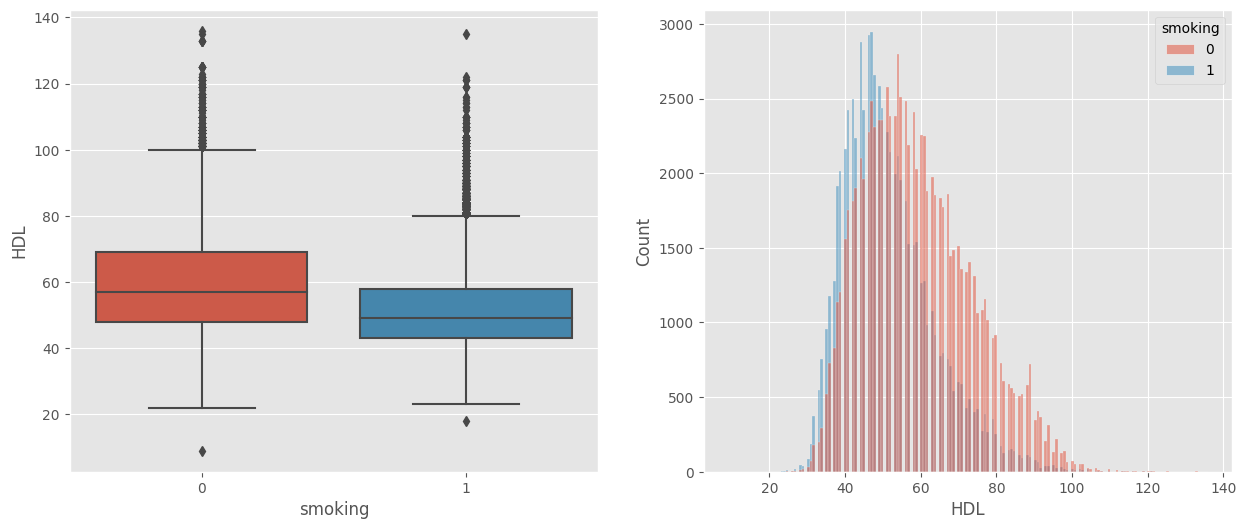

In [19]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.boxplot(ax = axes[0], data = train, x = 'smoking', y = 'HDL');
sns.histplot(data = train, x = 'HDL', hue = 'smoking');

From the above charts, we see that non-smokers, on average, have higher `HDL` than smokers. Next, we explore the relationship between `LDL` and `smoking`.

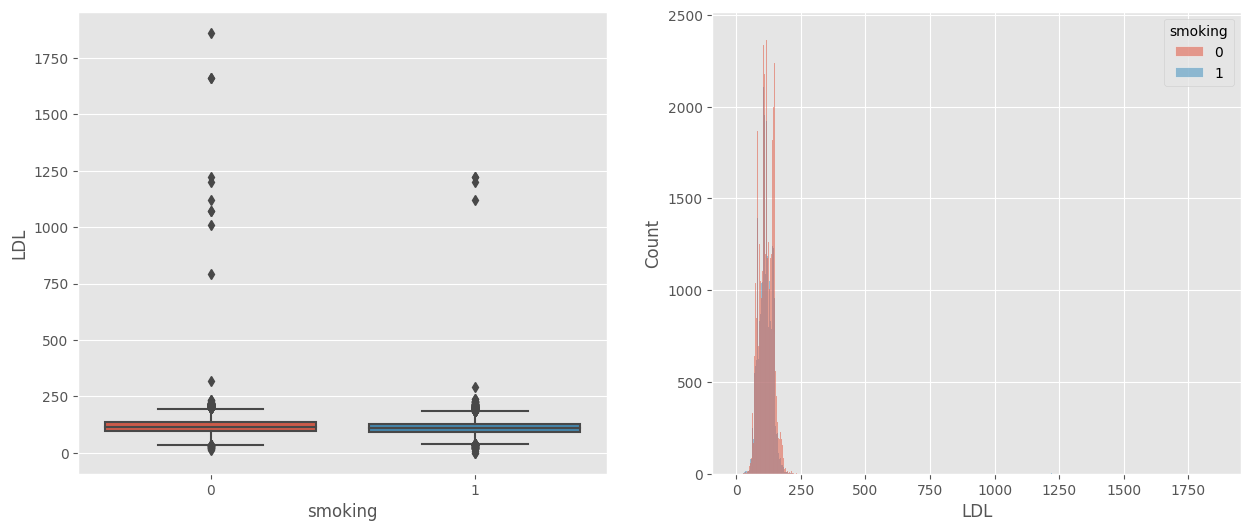

In [20]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.boxplot(ax = axes[0], data = train, x = 'smoking', y = 'LDL');
sns.histplot(data = train, x = 'LDL', hue = 'smoking');

The `LDL` distributions of non-smokers and smokers are very similar. Next, we explore the relationship between `hemoglobin` and `smoking`.

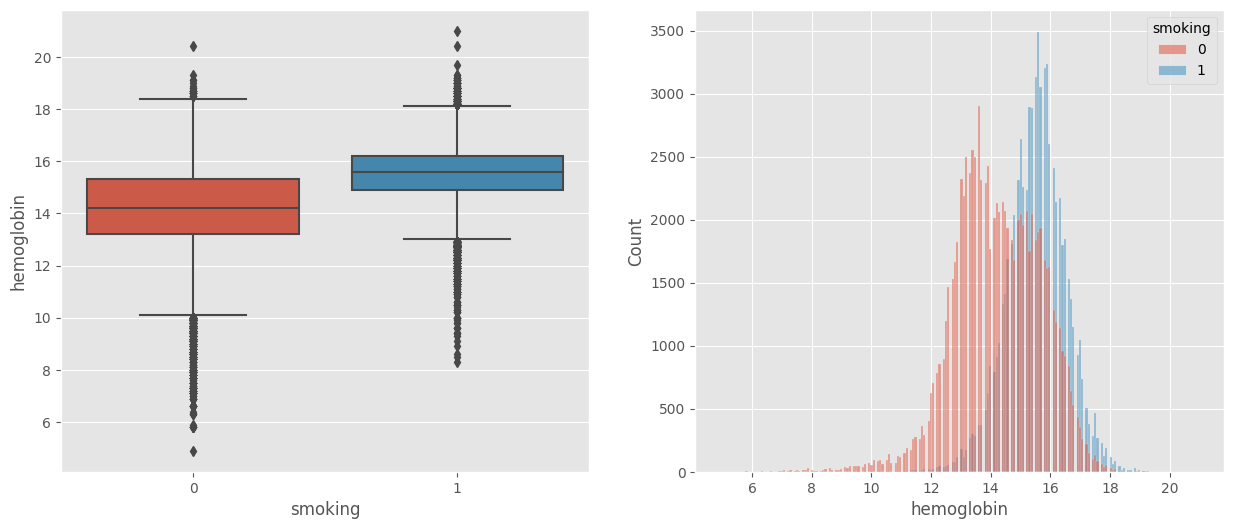

In [21]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.boxplot(ax = axes[0], data = train, x = 'smoking', y = 'hemoglobin');
sns.histplot(data = train, x = 'hemoglobin', hue = 'smoking');

From the above, it is clear the `hemoglobin` of smokers, on average, is higher. Next we explore the relationship between `Urine protein` and `smoking`.

In [22]:
pd.crosstab(train['Urine protein'], train['smoking'])

smoking,0,1
Urine protein,,
1,84311,66551
2,3549,2060
3,1402,826
4,287,190
5,48,26
6,6,0


Notice that there are only six observations with `Urine protein = 6`. Next we explote the relationship between `serum creatinine` and `smoking`.

In [23]:
pd.crosstab(train['serum creatinine'], train['smoking'])

smoking,0,1
serum creatinine,,
0.1,4,13
0.2,3,0
0.3,4,1
0.4,298,13
0.5,2444,180
0.6,10161,992
0.7,15583,4199
0.8,18540,11262
0.9,16637,19139


From the above table, there are a couple of `serum creatinine` values that are different from the others (5.9, 7.4, and 9.9). Next, we explore the relationship between `Gtp` and `smoking`.

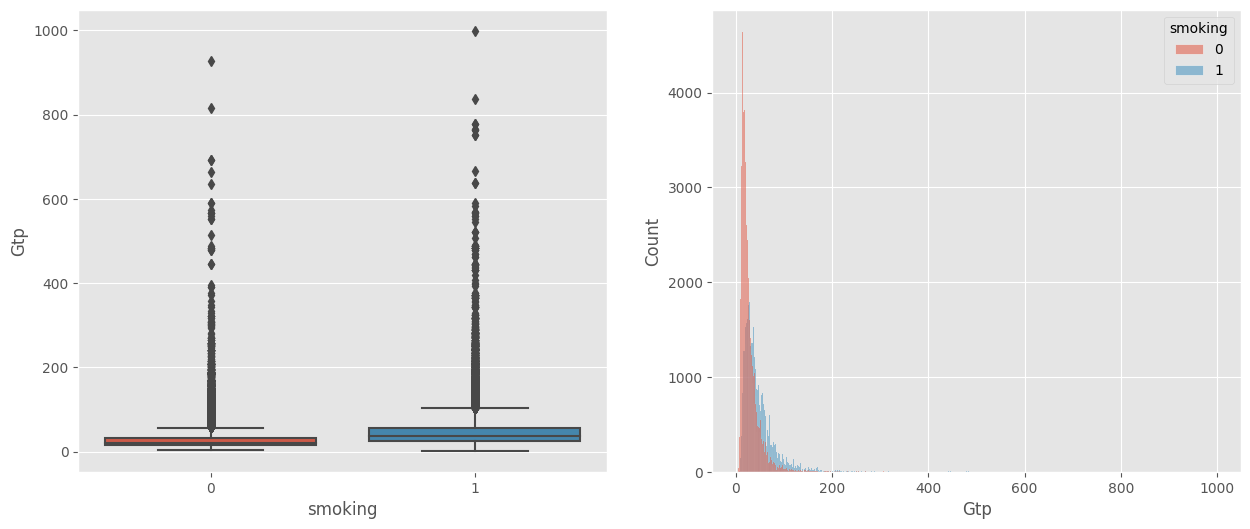

In [24]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.boxplot(ax = axes[0], data = train, x = 'smoking', y = 'Gtp');
sns.histplot(data = train, x = 'Gtp', hue = 'smoking');

From the above, smokers, on average, have a higher `Gtp`. Next, we explore the relationship between `dental caries` and `smoking`.

In [25]:
pd.crosstab(train['dental caries'], train['smoking'], normalize = 'index')

smoking,0,1
dental caries,,
0,0.588918,0.411082
1,0.456172,0.543828


From the above, we see that when `dental caries = 0`, the likelihood of being smoker is about 41%. On the other hand, when `dental caries = 1`, the likelihood of being smoker is about 54%. These are some takeaways from the initial EDA:

- The relationship between some of input features and `smoking` is not clear (or not clear distinction between the distribution of the two groups).
- Some of the features have a more clear relationship with `smoking` (`height`, `triglyceride`, and `hemoglobin`).

<a id="5"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 1.0</h1>

We start by modeling raw data without with minimum transformation and `LogisticRegression`. First, we define the input, target variables and the cross-validation folds.

In [26]:
X = train.drop(columns = ['id', 'smoking'], axis = 1)
Y = train['smoking']

skf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1, random_state = 42)

Then, we define the list of features to be transformed.

In [27]:
to_transform = ['age',
 'height(cm)',
 'weight(kg)',
 'waist(cm)',
 'eyesight(left)',
 'eyesight(right)',
 'systolic',
 'relaxation',
 'fasting blood sugar',
 'Cholesterol',
 'triglyceride',
 'HDL',
 'LDL',
 'hemoglobin',
 'serum creatinine',
 'AST',
 'ALT',
 'Gtp']

We are now ready to run the usual cross-validation routine with `LogisticRegression`.

In [28]:
Logit_cv_routine = cross_val_score(Pipeline([('stan-tran', ColumnTransformer([('stand', PowerTransformer(), to_transform)], remainder = 'passthrough')), 
                                             ('LR', LogisticRegression(C = 0.1, 
                                                                       max_iter = 2000, 
                                                                       solver = 'newton-cholesky'))]),
                                   X,
                                   Y,
                                   scoring = 'roc_auc',
                                   cv = skf, 
                                   n_jobs = -1)

print(f"The average oof ROC-AUC score of the Logistic model is {Logit_cv_routine.mean()}")

The average oof ROC-AUC score of the Logistic model is 0.8399016926382104


After that, we run the cross-validation routine with `RandomForestClassifier`.

In [29]:
RF_cv_routine = cross_val_score(RandomForestClassifier(random_state = 42), 
                                X,
                                Y,
                                scoring = 'roc_auc',
                                cv = skf, 
                                n_jobs = -1)

print(f"The average oof ROC-AUC score of the RF model is {RF_cv_routine.mean()}")

The average oof ROC-AUC score of the RF model is 0.8574054899726404


Next, we run the cross-validation routine with `ExtraTreesClassifier`.

In [30]:
ET_cv_routine = cross_val_score(ExtraTreesClassifier(random_state = 42), 
                                X,
                                Y,
                                scoring = 'roc_auc',
                                cv = skf, 
                                n_jobs = -1)

print(f"The average oof ROC-AUC score of the ET model is {ET_cv_routine.mean()}")

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The average oof ROC-AUC score of the ET model is 0.8536517680496709


Next, we run the cross-validation routine with `HistGradientBoosting`.

In [31]:
HistGB_cv_routine = cross_val_score(HistGradientBoostingClassifier(), 
                                    X,
                                    Y,
                                    scoring = 'roc_auc',
                                    cv = skf, 
                                    n_jobs = -1)

print(f"The average oof ROC-AUC score of the HistGB model is {HistGB_cv_routine.mean()}")

The average oof ROC-AUC score of the HistGB model is 0.8649994362558628


Next, we run the cross-validation routine with `LightGBM`.

In [32]:
LGBM_cv_routine = cross_val_score(LGBMClassifier(), 
                                  X,
                                  Y,
                                  scoring = 'roc_auc',
                                  cv = skf, 
                                  n_jobs = -1)

print(f"The average oof ROC-AUC score of the LGBM model is {LGBM_cv_routine.mean()}")

The average oof ROC-AUC score of the LGBM model is 0.8651370955221086


Next, we run the cross-validation routine with `XGBoost`.

In [33]:
XGB_cv_routine = cross_val_score(XGBClassifier(), 
                                 X,
                                 Y,
                                 scoring = 'roc_auc',
                                 cv = skf, 
                                 n_jobs = -1)

print(f"The average oof ROC-AUC score of the XGB model is {XGB_cv_routine.mean()}")

The average oof ROC-AUC score of the XGB model is 0.8661136485261356


Next, we run the cross-validation routine with `CatBoost`

In [34]:
Cat_cv_routine = cross_val_score(CatBoostClassifier(verbose = False), 
                                 X,
                                 Y,
                                 scoring = 'roc_auc',
                                 cv = skf, 
                                 n_jobs = -1)

print(f"The average oof ROC-AUC score of the CatBoost model is {Cat_cv_routine.mean()}")

The average oof ROC-AUC score of the CatBoost model is 0.8693534939540971


From the above results, `CatBoostClassifier` is the model with the highest oof `ROC-AUC` score. Finally, we ensemble the three models with `VotingClassifier` as follows. 

In [35]:
md1 = Pipeline([('stan-tran', ColumnTransformer([('stand', PowerTransformer(), to_transform)], remainder = 'passthrough')), 
                ('LR', LogisticRegression(C = 0.1, 
                                          max_iter = 2000, 
                                          solver = 'newton-cholesky'))])

md2 = RandomForestClassifier(random_state = 42)
md3 = ExtraTreesClassifier(random_state = 42)
md4 = HistGradientBoostingClassifier()
md5 = LGBMClassifier()
md6 = XGBClassifier()
md7 = CatBoostClassifier(verbose = False)

voting_ens = VotingClassifier(estimators = [('LR', md1), 
                                            ('RF', md2), 
                                            ('ET', md3), 
                                            ('HGB', md4),
                                            ('LGBM', md5),
                                            ('XGB', md6),
                                            ('Cat', md7)],
                              voting = 'soft',
                              weights = [1, 2, 2, 3, 3, 3, 4], 
                              n_jobs = -1).fit(X, Y)

In [36]:
submission['smoking'] = voting_ens.predict_proba(test.drop(columns = 'id', axis = 1))[:, 1]
submission.head()

,id,smoking
0,159256,0.586011
1,159257,0.237557
2,159258,0.460127
3,159259,0.022881
4,159260,0.621174


In [37]:
submission.to_csv('VotingClassifier_baseline_submission.csv', index = False)

<a id="6"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 2.0</h1>

In this section, we consider the same models from the previous section; however, in this section, we will stack the model predictions with `LogisticRegression`. First, we stacker as follows:

In [38]:
stacker = StackingClassifier(estimators = [('LR', md1),
                                           ('RF', md2),
                                           ('ET', md3),
                                           ('HGB', md4),
                                           ('LGBM', md5),
                                           ('XGB', md6),
                                           ('Cat', md7)],
                             final_estimator = LogisticRegression(C = 0.1,
                                                                  penalty = 'l1',
                                                                  solver = 'saga'))
stacker

StackingClassifier(estimators=[('LR',
                                Pipeline(steps=[('stan-tran',
                                                 ColumnTransformer(remainder='passthrough',
                                                                   transformers=[('stand',
                                                                                  PowerTransformer(),
                                                                                  ['age',
                                                                                   'height(cm)',
                                                                                   'weight(kg)',
                                                                                   'waist(cm)',
                                                                                   'eyesight(left)',
                                                                                   'eyesight(right)',
                                                                                   'systolic',
                                                                                   'relaxation',
                                                                                   'fasting '
                                                                                   'blood '
                                                                                   'sugar',
                                                                                   'Cholesterol',
                                                                                   'triglyceride',
                                                                                   'HDL',
                                                                                   'LDL',
                                                                                   'hemoglobin',
                                                                                   'serum '
                                                                                   'creatinine...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...)),
                               ('Cat',
                                <catboost.core.CatBoostClassifier object at 0x7dffb8b5a6b0>)],
                   final_estimator=LogisticRegression(C=0.1, penalty='l1',
                                                      solver='saga'))

Next, we generate the predictions for each of the considered model in the `train` dataset using a 10-fold cross validation as follows:

In [39]:
logit_train_preds = cross_val_predict(md1, X, Y, cv = skf, method = 'predict_proba', n_jobs = -1)
RF_train_preds = cross_val_predict(md2, X, Y, cv = skf, method = 'predict_proba', n_jobs = -1)
ET_train_preds = cross_val_predict(md3, X, Y, cv = skf, method = 'predict_proba', n_jobs = -1)
HGB_train_preds = cross_val_predict(md4, X, Y, cv = skf, method = 'predict_proba', n_jobs = -1)
LGB_train_preds = cross_val_predict(md5, X, Y, cv = skf, method = 'predict_proba', n_jobs = -1)
XGB_train_preds = cross_val_predict(md6, X, Y, cv = skf, method = 'predict_proba', n_jobs = -1)
Cat_train_preds = cross_val_predict(md7, X, Y, cv = skf, method = 'predict_proba', n_jobs = -1)

md_pred = pd.DataFrame()
md_pred['LR'] = logit_train_preds[:, 1]
md_pred['RF'] = RF_train_preds[:, 1]
md_pred['ET'] = ET_train_preds[:, 1]
md_pred['HGB'] = HGB_train_preds[:, 1]
md_pred['LGB'] = LGB_train_preds[:, 1]
md_pred['XGB'] = XGB_train_preds[:, 1]
md_pred['Cat'] = Cat_train_preds[:, 1]
md_pred['smoking'] = Y
md_pred.head()

,LR,RF,ET,HGB,LGB,XGB,Cat,smoking
0,0.795756,0.72,0.67,0.677984,0.745426,0.814776,0.711477,1
1,0.502904,0.35,0.33,0.345759,0.335757,0.266743,0.349800,0
2,0.898699,0.76,0.67,0.886141,0.910533,0.883100,0.945137,1
3,0.871707,0.67,0.74,0.739194,0.746784,0.705397,0.675690,0
4,0.405129,0.50,0.43,0.559184,0.578641,0.562688,0.472030,1


Finally, we train the stacker, and we use it to make predictions on the `test` dataset.

In [40]:
md1_fit = md1.fit(X, Y)
md2_fit = md2.fit(X, Y)
md3_fit = md3.fit(X, Y)
md4_fit = md4.fit(X, Y)
md5_fit = md5.fit(X, Y)
md6_fit = md6.fit(X, Y)
md7_fit = md7.fit(X, Y)

md_pred_test = pd.DataFrame()
md_pred_test['LR'] = md1_fit.predict_proba(test.drop(columns = 'id', axis = 1))[:, 1]
md_pred_test['RF'] = md2_fit.predict_proba(test.drop(columns = 'id', axis = 1))[:, 1]
md_pred_test['ET'] = md3_fit.predict_proba(test.drop(columns = 'id', axis = 1))[:, 1]
md_pred_test['HGB'] = md4_fit.predict_proba(test.drop(columns = 'id', axis = 1))[:, 1]
md_pred_test['LGB'] = md5_fit.predict_proba(test.drop(columns = 'id', axis = 1))[:, 1]
md_pred_test['XGB'] = md6_fit.predict_proba(test.drop(columns = 'id', axis = 1))[:, 1]
md_pred_test['Cat'] = md7_fit.predict_proba(test.drop(columns = 'id', axis = 1))[:, 1]

X_stack = md_pred.drop(columns = ['smoking'], axis = 1)
Y_stack = md_pred['smoking']

Ridge_stacker = LogisticRegression(C = 0.1,
                                   penalty = 'l1',
                                   solver = 'saga', 
                                   random_state = 42).fit(X_stack, Y_stack)

submission['smoking'] = Ridge_stacker.predict_proba(md_pred_test)[:, 1]
submission.head()

,id,smoking
0,159256,0.606350
1,159257,0.192923
2,159258,0.382704
3,159259,0.046499
4,159260,0.649408


In [41]:
submission.to_csv('StackingClassifier_baseline_submission.csv', index = False)